# Mechanistic modeling of VMHvl line attractor dynamics

By Charles Xu @ Caltech, 2024.

This notebook builds on the work by Isa in 2024 to further generalize on other plausible mechanisms of the implementation of the VMHvl line attractor.

## Environment

In [15]:
from vmhvl_snn_sim import VMHvlSNNSimulation
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.stats as stats
import pickle
from datetime import datetime

## Local slow synaptic dynamics model

In [16]:
# Create connectivity matrix
x1_percentage = 0.2
x2_percentage = 0
N = 1000
Nx1 = int(round(N * x1_percentage))

W = np.random.rand(N, N) * (np.random.rand(N, N) < 0.01) / np.sqrt(N)   # Make a matrix with very sparse (1%) connectivity
Wx1 = np.random.uniform(0, 1/np.sqrt(N), (N, N))
Wx1 = np.random.rand(Nx1, Nx1) * (np.random.rand(Nx1, Nx1) < 0.36) / np.sqrt(Nx1)  # Set sparsity of subnetwork
W[:Nx1, :Nx1] = Nx1

In [17]:
# Create an instance of the simulation class
snn = VMHvlSNNSimulation(x1_percentage, x2_percentage,
                         N=N,
                         W=W,
                         threshold=0.1,
                         v_r=0,
                         tau_s=20e3,
                         n_pulses=4,
                         g_input=6,
                         dt=0.005e3,
                         simulation_time=200e3,
                         noise=0.1)

In [18]:
# Run the simulation
# snn.run_simulation()

In [19]:
# Save simulation object
# current_time = datetime.now().strftime('%Y%m%d%H%M%S')
# save_path = f'/home/charlesxu/local/data/vmhvl_snn/snn_{current_time}.pkl'
# with open(save_path, 'wb') as f:
#     pickle.dump(snn, f)
# print(f'Simulation object saved to {save_path}')

In [20]:
# Read simulation object
read_path = '/home/charlesxu/local/data/vmhvl_snn/snn_N1000T200e3_expsmooth.pkl'
with open(read_path, 'rb') as f:
    snn = pickle.load(f)
print(f'Simulation object loaded from {read_path}')

Simulation object loaded from /home/charlesxu/local/data/vmhvl_snn/snn_N1000T200e3_expsmooth.pkl


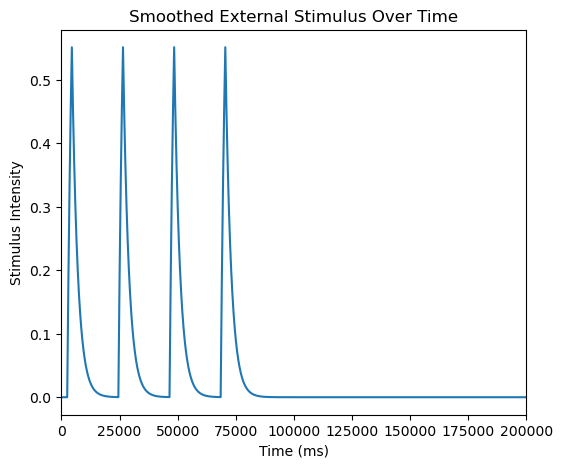

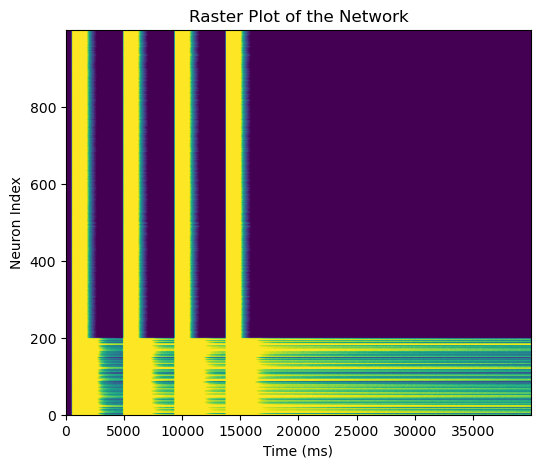

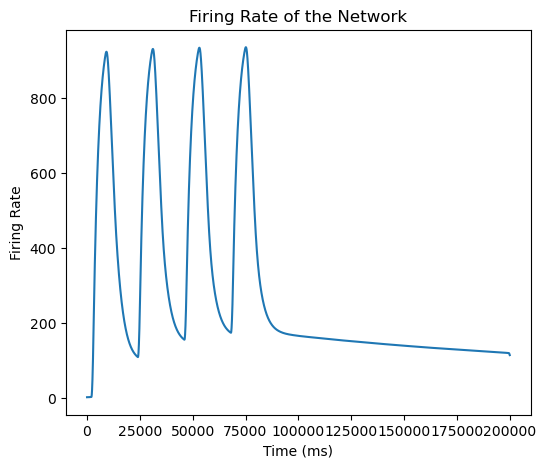

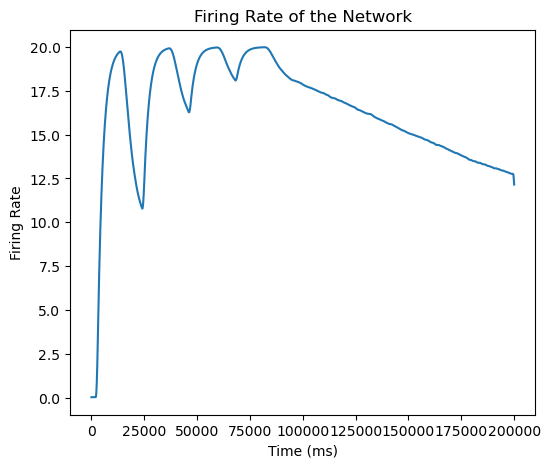

In [21]:
# Plot the stimulus
snn.plot_stimulus()

# Plot the simulation results
snn.plot_raster()
snn.plot_network_rate()
snn.plot_network_rate(cell_idx=np.arange(20))

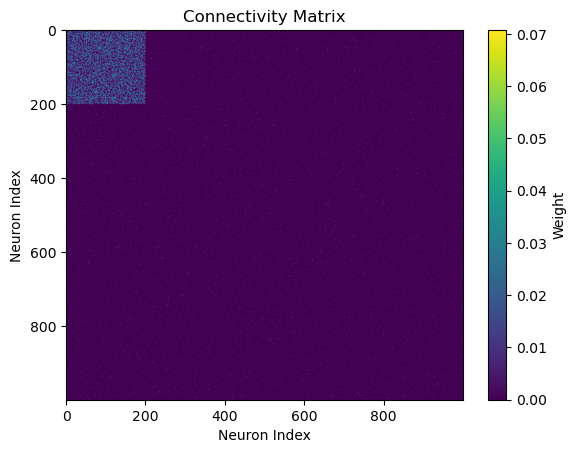

In [22]:
# Plot the connectivity matrix
plt.imshow(snn.W, cmap='viridis', aspect='auto')
plt.colorbar(label='Weight')
plt.title('Connectivity Matrix')
plt.xlabel('Neuron Index')
plt.ylabel('Neuron Index')
plt.show()

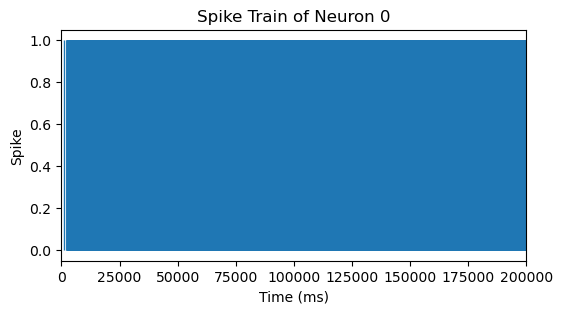

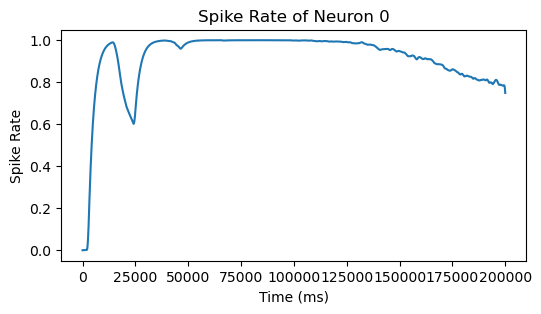

In [23]:
# Plot individual spike trains
snn.plot_spike_train()
snn.plot_spike_rate()

## Fitted degree distribution model

In [199]:
# Read and process the connectivity distributions
dist_mat_path = 'distribution_pairwise_vinograd_nair.mat'
dist_mat = sio.loadmat(dist_mat_path)
dist_x1 = dist_mat['all_dist_mean_x1']
dist_x2 = dist_mat['all_dist_mean_x2']
dist_x1 = np.squeeze(dist_x1)
dist_x2 = np.squeeze(dist_x2)

In [200]:
# # What if I turn the distributions to non-negative?
# dist_x1 = dist_x1 - np.min(dist_x1)
# dist_x2 = dist_x2 - np.min(dist_x2)

In [201]:
# # What if I take out the negative values?
# dist_x1 = dist_x1[dist_x1 >= 0]
# dist_x2 = dist_x2[dist_x2 >= 0]

In [202]:
print(np.min(dist_x1), np.min(dist_x2))

-0.9531129914071409 -0.6064009700241193


### Fit the distributions

Exponential distribution KS statistic on x1: 0.37378708688240136, p-value: 1.522686568778958e-10
Gamma distribution KS statistic on x1: 0.08728836068538459, p-value: 0.5464469453535334


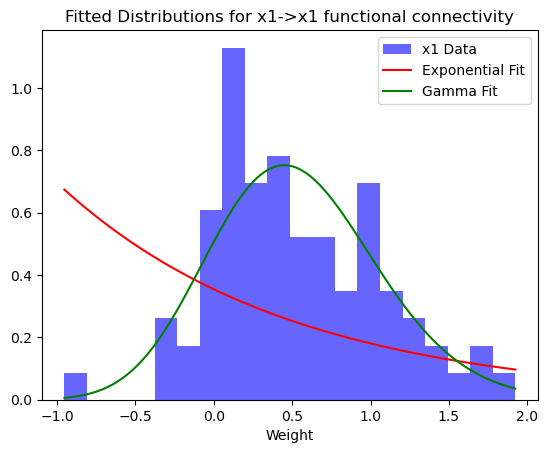

In [203]:
## Fit for x1->x1 functional connectivity

# Fit parameters
x1_exp_fit = stats.expon.fit(dist_x1)
x1_gamma_fit = stats.gamma.fit(dist_x1)

# Goodness of fit
x1_exp_ks = stats.kstest(dist_x1, 'expon', args=x1_exp_fit)
x1_gamma_ks = stats.kstest(dist_x1, 'gamma', args=x1_gamma_fit)
print(f'Exponential distribution KS statistic on x1: {x1_exp_ks[0]}, p-value: {x1_exp_ks[1]}')
print(f'Gamma distribution KS statistic on x1: {x1_gamma_ks[0]}, p-value: {x1_gamma_ks[1]}')

# Plot the histogram and the fitted distributions
x = np.linspace(np.min(dist_x1), np.max(dist_x1), 100)
x1_exp_pdf = stats.expon.pdf(x, *x1_exp_fit)
x1_gamma_pdf = stats.gamma.pdf(x, *x1_gamma_fit)
plt.hist(dist_x1, bins=20, density=True, alpha=0.6, color='b', label='x1 Data')
plt.plot(x, x1_exp_pdf, 'r-', label='Exponential Fit')
plt.plot(x, x1_gamma_pdf, 'g-', label='Gamma Fit')
plt.xlabel('Weight')
plt.legend()
plt.title('Fitted Distributions for x1->x1 functional connectivity')
plt.show()

Exponential distribution KS statistic on x2: 0.35192278270722177, p-value: 3.008171224219629e-11
Gamma distribution KS statistic on x2: 0.07874410533157322, p-value: 0.557533510696288


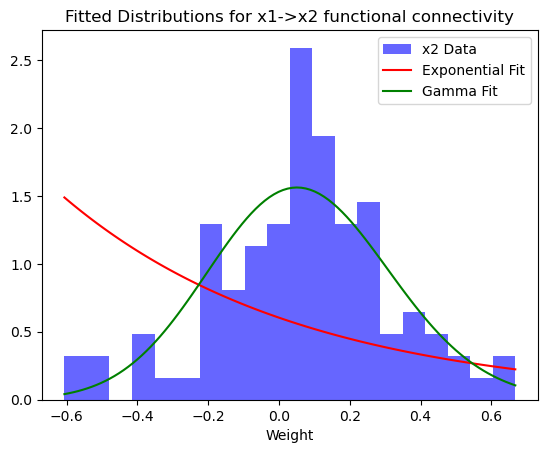

In [204]:
## Fit for x1->x2 functional connectivity

# Fit parameters
x1x2_exp_fit = stats.expon.fit(dist_x2)
x1x2_gamma_fit = stats.gamma.fit(dist_x2)

# Goodness of fit
x1x2_exp_ks = stats.kstest(dist_x2, 'expon', args=x1x2_exp_fit)
x1x2_gamma_ks = stats.kstest(dist_x2, 'gamma', args=x1x2_gamma_fit)
print(f'Exponential distribution KS statistic on x2: {x1x2_exp_ks[0]}, p-value: {x1x2_exp_ks[1]}')
print(f'Gamma distribution KS statistic on x2: {x1x2_gamma_ks[0]}, p-value: {x1x2_gamma_ks[1]}')

# Plot the histogram and the fitted distributions
x = np.linspace(np.min(dist_x2), np.max(dist_x2), 100)
x1x2_exp_pdf = stats.expon.pdf(x, *x1x2_exp_fit)
x1x2_gamma_pdf = stats.gamma.pdf(x, *x1x2_gamma_fit)

plt.hist(dist_x2, bins=20, density=True, alpha=0.6, color='b', label='x2 Data')
plt.plot(x, x1x2_exp_pdf, 'r-', label='Exponential Fit')
plt.plot(x, x1x2_gamma_pdf, 'g-', label='Gamma Fit')
plt.xlabel('Weight')
plt.legend()
plt.title('Fitted Distributions for x1->x2 functional connectivity')
plt.show()

### Create connectivity matrix

Create the connectivity matrix based on fitted functional connectivity.

In [205]:
print(f'x1->x1 gamma fit: shape={x1_gamma_fit[0]}, loc={x1_gamma_fit[1]}, scale={x1_gamma_fit[2]}')
print(f'x1->x2 gamma fit: shape={x1x2_gamma_fit[0]}, loc={x1x2_gamma_fit[1]}, scale={x1x2_gamma_fit[2]}')

x1->x1 gamma fit: shape=44.368787778485, loc=-3.034318925109792, scale=0.08032542630074754
x1->x2 gamma fit: shape=374.0727911772426, loc=-4.883181482316137, scale=0.013224965592824819


In [206]:
# Create connectivity matrix from fitted distributions
x1_percentage = 0.2
x2_percentage = 0.2
N = 1000
W = np.zeros((N, N))
W = np.random.rand(N, N) * (np.random.rand(N, N) < 0.01) / np.sqrt(N)   # Make a matrix with very sparse (1%) connectivity
Nx1 = int(round(N * x1_percentage))
Nx2 = int(round(N * x2_percentage))

# Create x1 connectivity
Wx1 = np.zeros((Nx1, Nx1))
Wx1 = np.random.gamma(x1_gamma_fit[0], x1_gamma_fit[2], (Nx1, Nx1))
Wx1 += x1_gamma_fit[1]

# Create x2 connectivity
# x2 connectivity remains unspecified and sparse

# Create x1 to x2 connectivity
Wx1x2 = np.zeros((Nx1, Nx2))
Wx1x2 = np.random.gamma(x1x2_gamma_fit[0], x1x2_gamma_fit[2], (Nx1, Nx2))
Wx1x2 += x1x2_gamma_fit[1]

# Normalize the weights
norm_factor = max(np.max(np.abs(Wx1)), np.max(np.abs(Wx1x2))) / (1 / np.sqrt(Nx1 + Nx2))
Wx1 = Wx1 / norm_factor
Wx1x2 = Wx1x2 / norm_factor
W[:Nx1, :Nx1] = Wx1             # Set x1 connectivity on the diagonal of the connectivity matrix
W[:Nx1, Nx1:Nx1+Nx2] = Wx1x2    # Set x1 to x2 connectivity in the upper triangle of the connectivity matrix

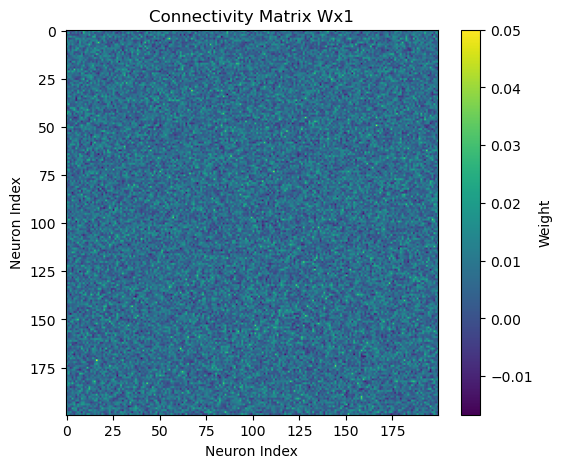

In [207]:
plt.figure(figsize=(6, 5))
plt.imshow(Wx1, cmap='viridis', aspect='auto')
plt.colorbar(label='Weight')
plt.title('Connectivity Matrix Wx1')
plt.xlabel('Neuron Index')
plt.ylabel('Neuron Index')
plt.show()

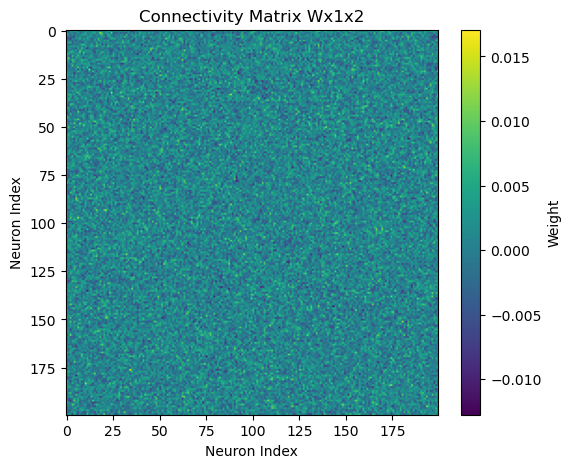

In [208]:
plt.figure(figsize=(6, 5))
plt.imshow(Wx1x2, cmap='viridis', aspect='auto')
plt.colorbar(label='Weight')
plt.title('Connectivity Matrix Wx1x2')
plt.xlabel('Neuron Index')
plt.ylabel('Neuron Index')
plt.show()

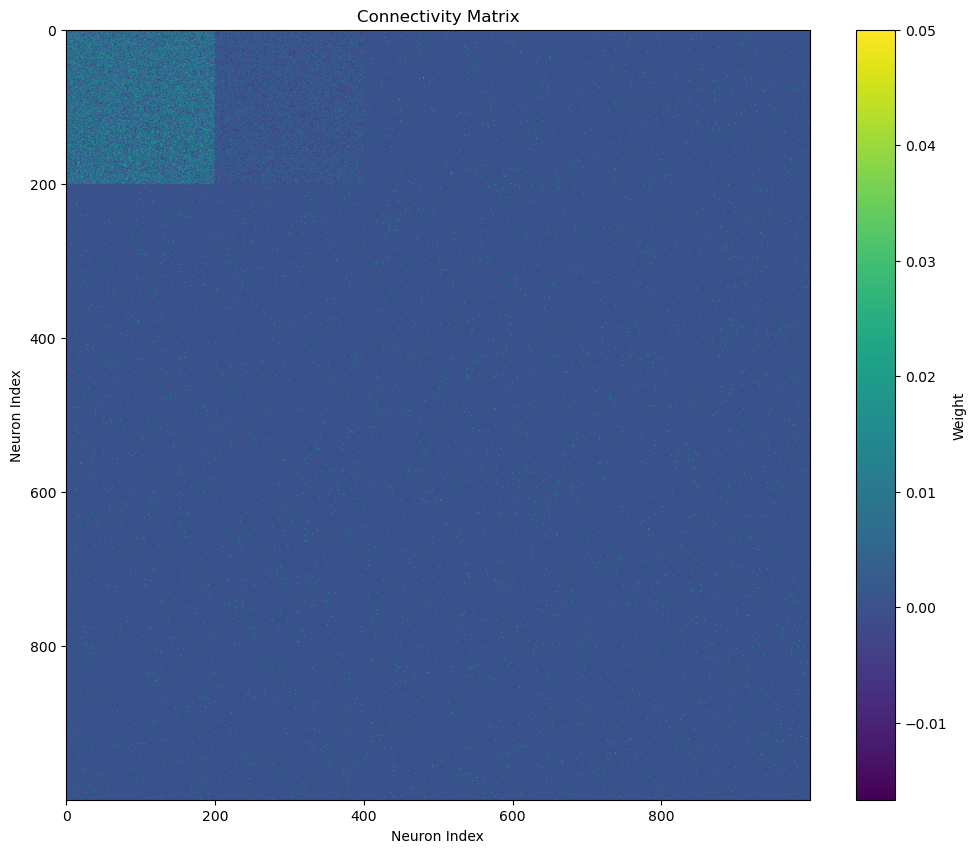

In [209]:
# Visualize the connectivity matrix
plt.figure(figsize=(12, 10))
plt.imshow(W, cmap='viridis', aspect='auto')
plt.colorbar(label='Weight')
plt.title('Connectivity Matrix')
plt.xlabel('Neuron Index')
plt.ylabel('Neuron Index')
plt.show()

In [210]:
# Create a new instance of the simulation class
snn = VMHvlSNNSimulation(x1_percentage, x2_percentage,
                         N=N,
                         W=W,
                         threshold=0.1,
                         v_r=0,
                         tau_s=20e3,
                         n_pulses=2,
                         g_input=6,
                         dt=0.005e3,
                         simulation_time=50e3,
                         noise=0.1)

In [211]:
# Run the simulation
snn.run_simulation()

Initializing simulation...
Simulating...
Simulation time: 49995/49996 ms
Simulation complete.
Spike history recorded.
Calculating spike rate history...
Smoothing...
Spike rate history recorded.


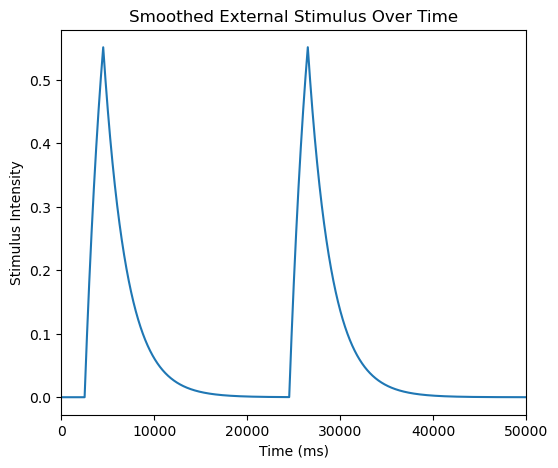

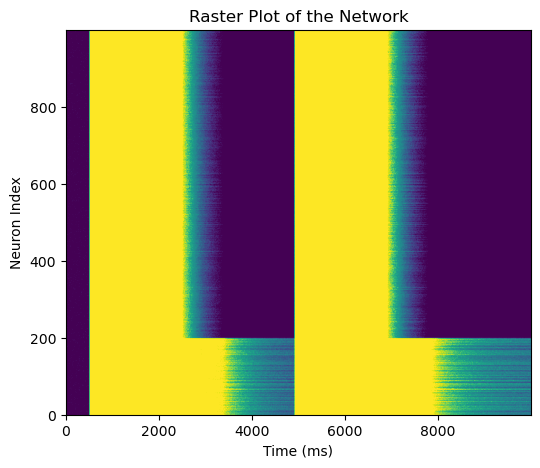

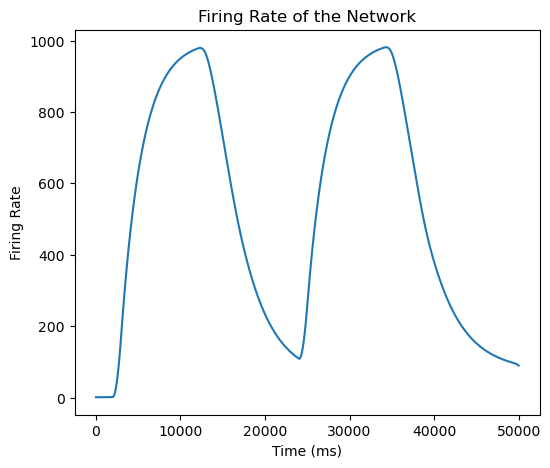

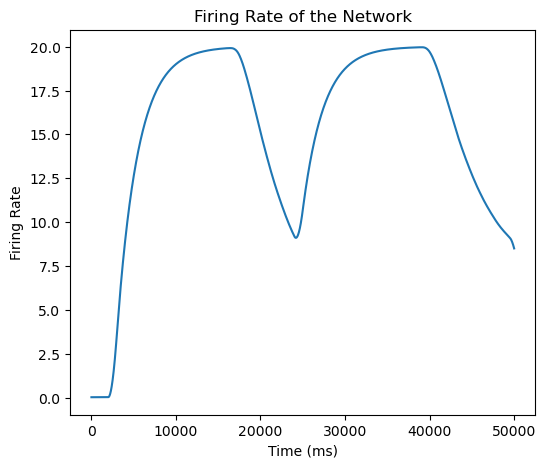

In [212]:
# Plot the stimulus
snn.plot_stimulus()

# Plot the simulation results
snn.plot_raster()
snn.plot_network_rate()
snn.plot_network_rate(cell_idx=np.arange(20))

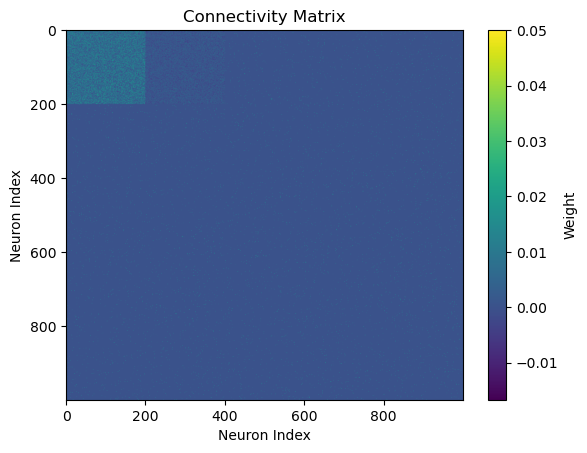

In [213]:
# Plot the connectivity matrix
plt.imshow(snn.W, cmap='viridis', aspect='auto')
plt.colorbar(label='Weight')
plt.title('Connectivity Matrix')
plt.xlabel('Neuron Index')
plt.ylabel('Neuron Index')
plt.show()

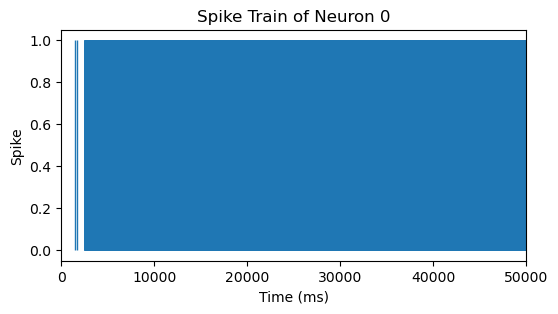

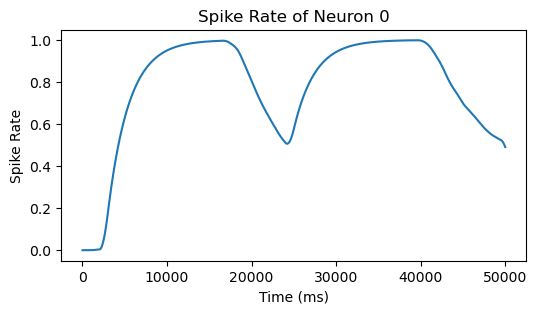

In [214]:
# Plot individual spike trains
snn.plot_spike_train()
snn.plot_spike_rate()

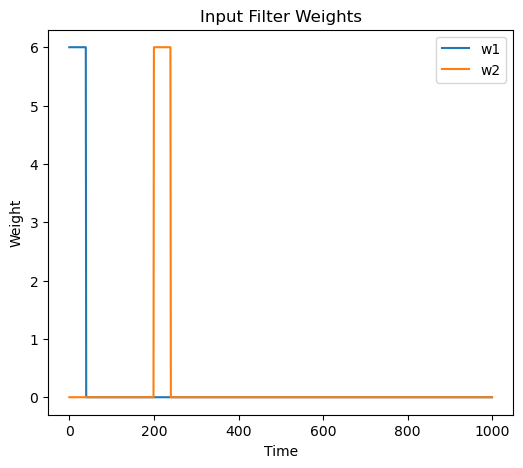

In [215]:
# Plot the input filter
plt.figure(figsize=(6, 5))
plt.plot(snn.w1, label='w1')
plt.plot(snn.w2, label='w2')
plt.xlabel('Time')
plt.ylabel('Weight')
plt.title('Input Filter Weights')
plt.legend()
plt.show()